In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import json

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [5.0, 3.0]
plt.rcParams['figure.dpi'] = 150
%matplotlib notebook

In [2]:
true_data = pd.read_csv("csv_data/srilanka.txt",sep=' ', skipinitialspace=True, \
                        skiprows=1, header=None, names=['confirmed', 'recovered', 'deaths'])
true_data

,confirmed,recovered,deaths
0,3382,3233,13
1,3388,3245,13
2,3395,3254,13
3,3402,3258,13
4,3513,3259,13
...,...,...,...
380,531070,0,13472
381,531648,0,13484
382,532218,0,13507
383,532766,0,13525


In [3]:
smoothed_data = pd.read_csv("../C++/build/release/results/srilanka_popsmooth.txt", skipinitialspace=True, \
                            header=None, names=['confirmed_true', 'deaths_true', 'confirmed_smooth', 'deaths_smooth'])
diff_data = smoothed_data.diff();
diff_data.loc[0] = 0
smoothed_data

,confirmed_true,deaths_true,confirmed_smooth,deaths_smooth
0,3382,13,3382,13
1,3388,13,3388,13
2,3395,13,3416,13
3,3402,13,3684,13
4,3513,13,3842,13
...,...,...,...,...
380,531070,13472,530899,13468
381,531648,13484,531598,13487
382,532218,13507,532201,13506
383,532766,13525,532763,13525


<IPython.core.display.Javascript object>


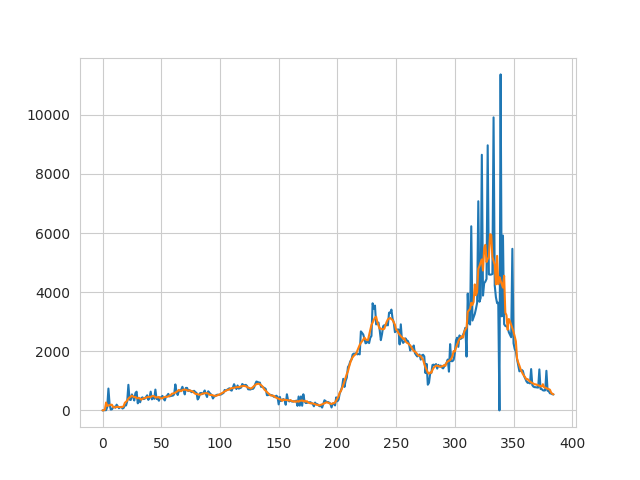

In [4]:
plt.figure()
plt.plot(diff_data['confirmed_true'])
plt.plot(diff_data['confirmed_smooth'])
plt.show()

<IPython.core.display.Javascript object>


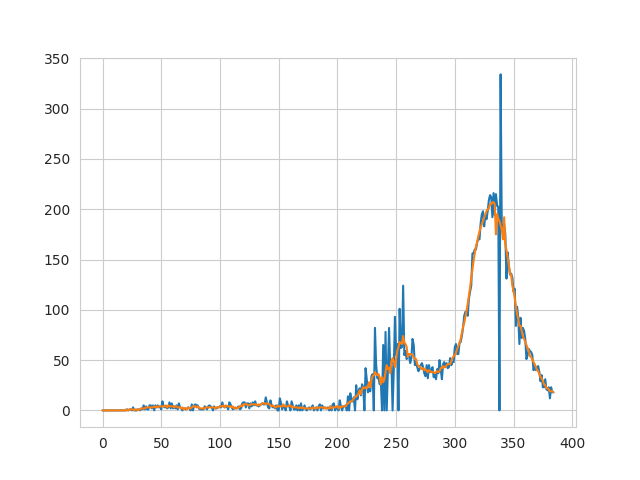

In [5]:
plt.figure()
plt.plot(diff_data['deaths_true'])
plt.plot(diff_data['deaths_smooth'])
plt.show()

In [7]:
pred_data = pd.read_csv("../C++/build/release/results/srilanka_prediction_seed1.txt", \
                        skipinitialspace=True)
#print("pred_data:\n", pred_data)
num_days = len(pred_data)
print("Num days:", num_days)

param_data = pd.read_csv("../C++/build/release/results/srilanka_params_seed1.txt", \
                        skipinitialspace=True,header=None)
# param_data = param_data.iloc[:, ::-1];
#print(param_data)

beta = param_data.loc[0:num_days-1]
c0 = param_data.loc[  num_days:2*num_days-1]
c1 = param_data.loc[2*num_days:3*num_days-1]
c2 = param_data.loc[3*num_days:4*num_days-1]
c3 = param_data.loc[4*num_days:5*num_days-1]
IFR = param_data.loc[5*num_days:6*num_days-1]
#print(IFR[0])

num_sol_to_plot = min(10, len(param_data.columns));

vaccine_eff = param_data.loc[param_data.index[-2]]
print("Vaccine effectiveness:\n",vaccine_eff)

optimal_params = {
    "beta": beta[0].tolist(),
    "c0"  : c0[0].tolist(),
    "c1"  : c1[0].tolist(),
    "c2"  : c2[0].tolist(),
    "c3"  : c3[0].tolist(),
    "IFR"  : IFR[0].tolist(),
    "vaccine_eff": vaccine_eff[0]
}

#Write optimal parameters as JS variable
opt_param_json_file = open("optimal_parameters.js", "w")
opt_param_json_file.write("let optimal_model_params = ")
json.dump(optimal_params, opt_param_json_file)
opt_param_json_file.close()

error = param_data.loc[param_data.index[-1]]
error_plot = error[0:num_sol_to_plot]
print("Error:\n",error)

scaled_error = (np.log(error_plot) - np.log(min(error_plot))) / (np.log(max(error_plot)) - np.log(min(error_plot))) * 0.9
print("Scaled error:\n", scaled_error)
grey_colors = np.tile(scaled_error,[3,1]).transpose();

# grey_colormap = matplotlib.colors.ListedColormap(grey_colors)
grey_colors[0] = [0.24, 0.63, 0.93] #Change color of best result to blue
print("Grey colors:\n", grey_colors)
# plt.figure()
# ax = sns.heatmap(np.random.rand(30,30))
# ax.pcolor(np.random.rand(30,30),cmap=grey_colormap)
# plt.show()

start_date = datetime.strptime("2020-10-1", "%Y-%m-%d")
dates = [];
for i in range(0,num_days):
    dates.append(start_date + timedelta(days=i))

locator = mdates.AutoDateLocator(minticks=4, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)

Num days: 385
Vaccine effectiveness:
 0    0.013658
1    0.052952
2    0.148290
3    0.000000
4    1.000000
Name: 2319, dtype: float64
Error:
 0    0.000259
1    0.000580
2    0.003940
3    0.574540
4    0.681796
Name: 2320, dtype: float64
Scaled error:
 0    0.000000
1    0.091846
2    0.310934
3    0.880436
4    0.900000
Name: 2320, dtype: float64
Grey colors:
 [[0.24       0.63       0.93      ]
 [0.09184596 0.09184596 0.09184596]
 [0.31093447 0.31093447 0.31093447]
 [0.8804359  0.8804359  0.8804359 ]
 [0.9        0.9        0.9       ]]


<IPython.core.display.Javascript object>


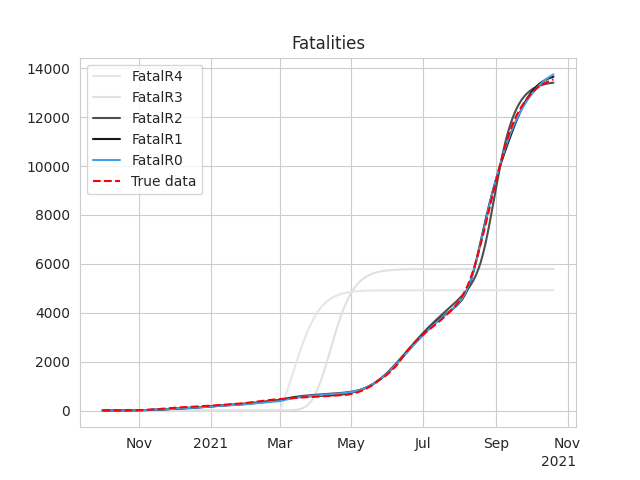

In [8]:
pred_fatal = pred_data.filter(regex=("FatalR.*"))

fig = plt.figure()

for i in range(num_sol_to_plot-1,-1,-1):
    plt.plot(dates,pred_fatal["FatalR"+str(i)], color=grey_colors[i])
    
plt.plot(dates,smoothed_data["deaths_smooth"],'r--')
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
    
labels = pred_fatal.columns[0:num_sol_to_plot][::-1].tolist();
labels.append("True data");
plt.legend(labels,loc='upper left')
plt.title('Fatalities')
plt.show()


<IPython.core.display.Javascript object>


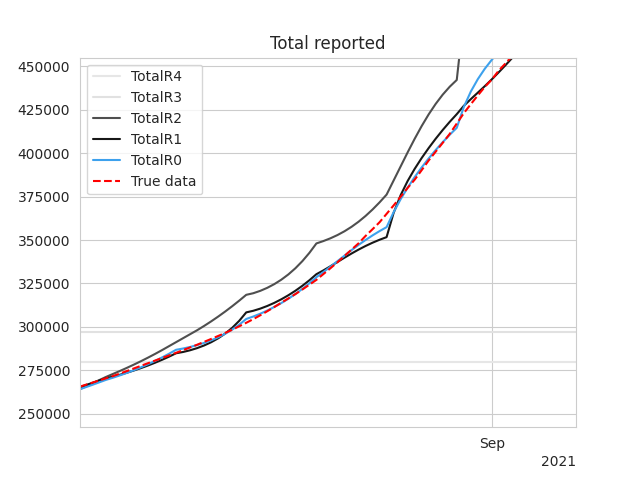

In [9]:
pred_reported = pred_data.filter(regex=("TotalR.*"))
# print(pred_reported)

plt.figure()

for i in range(num_sol_to_plot-1,-1,-1):
    plt.plot(dates, pred_reported["TotalR"+str(i)], color=grey_colors[i])

# plt.plot(pred_reported)
plt.plot(dates, smoothed_data["confirmed_smooth"],'r--')
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

labels = pred_reported.columns[0:num_sol_to_plot][::-1].tolist();
labels.append("True data");
plt.legend(labels,loc='upper left')
plt.title('Total reported')
plt.show()

<IPython.core.display.Javascript object>


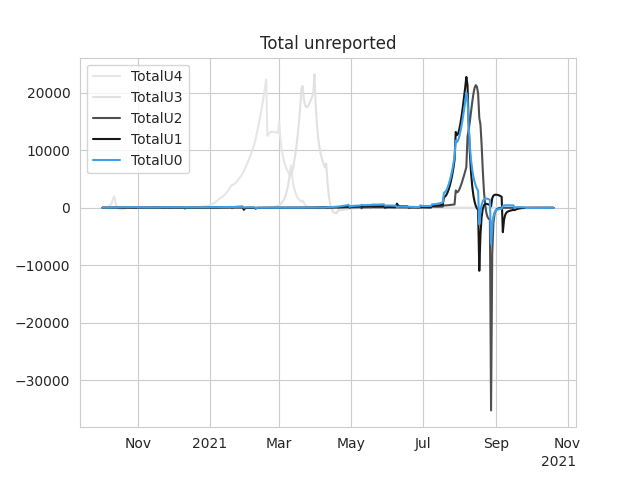

In [10]:
pred_unreported = pred_data.filter(regex=("TotalU.*"))
# print(pred_unreported)

plt.figure()

for i in range(num_sol_to_plot-1,-1,-1):
    plt.plot(dates, pred_unreported["TotalU"+str(i)].diff(), color=grey_colors[i])

ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

labels = pred_unreported.columns[0:num_sol_to_plot][::-1].tolist();
plt.legend(labels,loc='upper left')
plt.title('Total unreported')
plt.show()

        Reff0     Reff1     Reff2     Reff3  Reff4
0    0.358330  0.414415  0.554089  0.504647    0.0
1    0.358330  0.414415  0.554088  0.504646    0.0
2    0.358330  0.414415  0.554087  0.504646    0.0
3    0.358329  0.414414  0.554086  0.504646    0.0
4    0.358328  0.414413  0.554084  0.504646    0.0
..        ...       ...       ...       ...    ...
380  0.291044  0.000000  0.000000  0.000000    0.0
381  0.286332  0.000000  0.000000  0.000000    0.0
382  0.281605  0.000000  0.000000  0.000000    0.0
383  0.276866  0.000000  0.000000  0.000000    0.0
384  0.272114  0.000000  0.000000  0.000000    0.0

[385 rows x 5 columns]


<IPython.core.display.Javascript object>


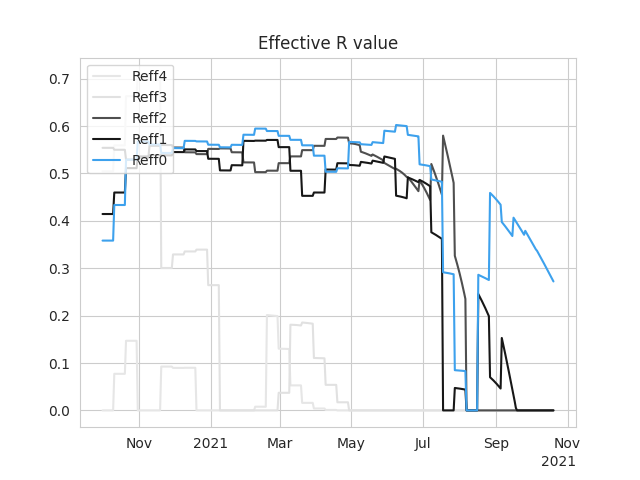

In [11]:
pred_Reff = pred_data.filter(regex=("Reff.*"))
print(pred_Reff)

plt.figure()

for i in range(num_sol_to_plot-1,-1,-1):
    plt.plot(dates, pred_Reff["Reff"+str(i)], color=grey_colors[i])

ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

labels = pred_Reff.columns[0:num_sol_to_plot][::-1].tolist();
plt.legend(labels,loc='upper left')
plt.title('Effective R value')
plt.show()

<IPython.core.display.Javascript object>


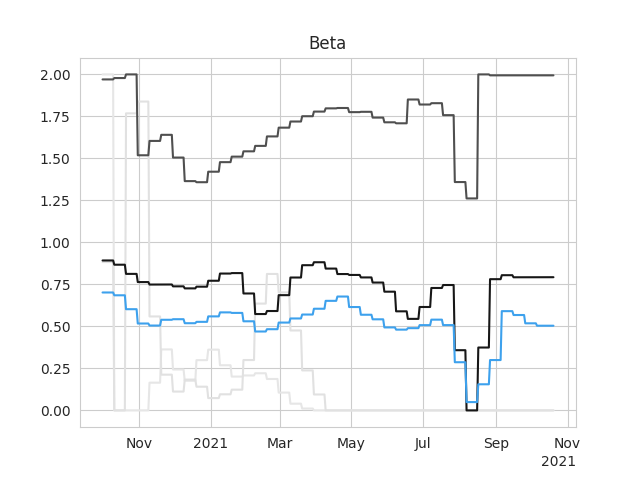

<IPython.core.display.Javascript object>


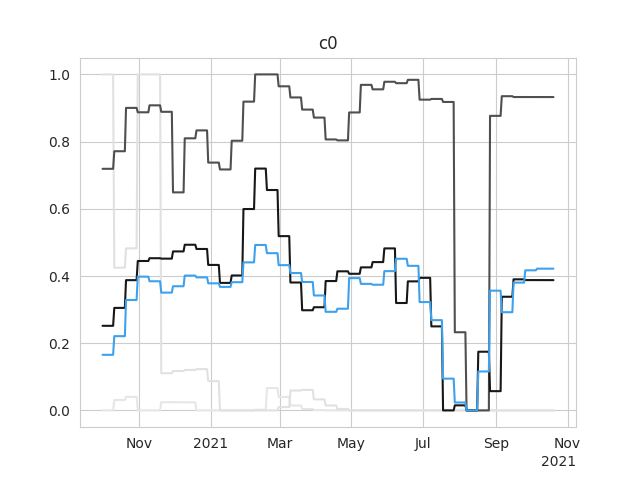

<IPython.core.display.Javascript object>


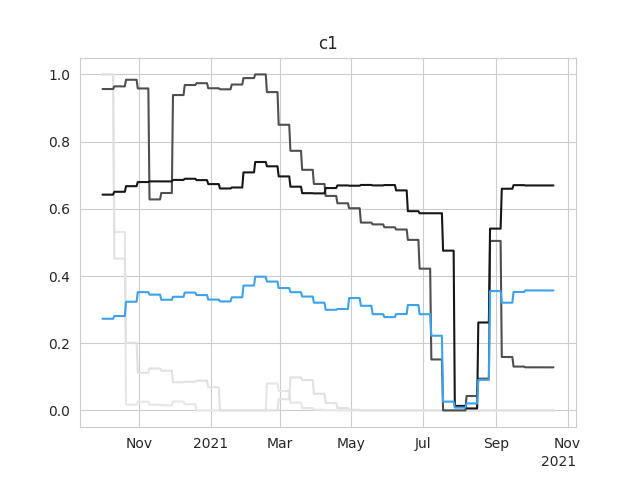

In [12]:
plt.figure()
for i in range(num_sol_to_plot-1,-1,-1):
    plt.plot(dates, beta[i], color=grey_colors[i])
# sns.lineplot(data=beta,palette=grey_colormap, dashes=False)
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.title('Beta')
plt.show()

plt.figure()
for i in range(num_sol_to_plot-1,-1,-1):
    plt.plot(dates, c0[i], color=grey_colors[i])
# sns.lineplot(data=c0,palette="Greys_r", dashes=False)
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.title('c0')
plt.show()

plt.figure()
for i in range(num_sol_to_plot-1,-1,-1):
    plt.plot(dates, c1[i], color=grey_colors[i])
# sns.lineplot(data=c1,palette="ch:s=.25,rot=-.25,reverse=1", dashes=False)
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.title('c1')
plt.show()

# print(sns.color_palette("light:#5A9")[0])

<IPython.core.display.Javascript object>


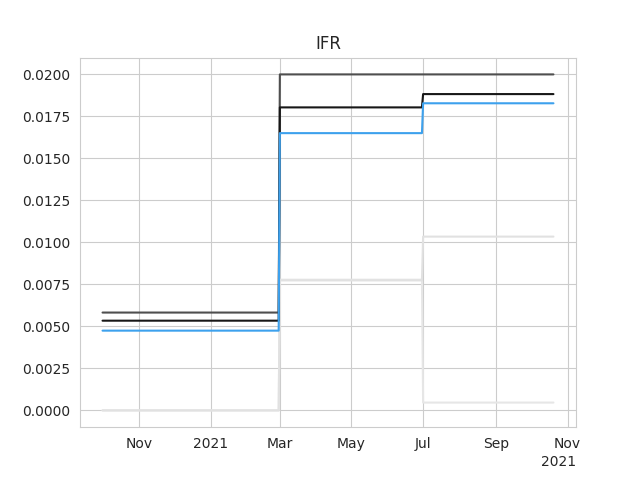

In [13]:
plt.figure()
for i in range(num_sol_to_plot-1,-1,-1):
    plt.plot(dates, IFR[i], color=grey_colors[i])
# sns.lineplot(data=IFR,palette="ch:s=.25,rot=-.25,reverse=1", dashes=False)
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.title('IFR')
plt.show()

In [14]:

err_t = (pred_data['TotalR0'] - smoothed_data["confirmed_smooth"])
err_f = (pred_data['FatalR0'] - smoothed_data["deaths_smooth"])
cost_t = np.linalg.norm(err_t)**2 / np.linalg.norm(smoothed_data["confirmed_smooth"])**2;
cost_f = np.linalg.norm(err_f)**2 / np.linalg.norm(smoothed_data["deaths_smooth"])**2
print(cost_t, cost_f, cost_t+cost_f)
#print(smoothed_data["confirmed_smooth"])

9.685903658263917e-05 0.00016261026333058666 0.00025946929991322584


In [15]:
print(err_t)
print(format(np.linalg.norm(smoothed_data["confirmed_smooth"])**2, '1.8e'))
print(format(np.linalg.norm(smoothed_data["deaths_smooth"])**2, '1.8e'))

0         0.000000
1        -0.679274
2       -19.247208
3      -274.436541
4      -416.484240
          ...     
380   -4080.890900
381   -4631.752920
382   -5106.044990
383   -5556.462170
384   -6001.938700
Length: 385, dtype: float64
2.25246359e+13
9.57868236e+09
